In [1]:
import numpy as np
import pandas as pd
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from utility.clean_data_func import clean_and_filter_data


def remove_special_characters(text):
    """Removes special characters from a text string."""
    pattern = r"[^\w\s]"  # Keep alphanumeric characters and whitespace
    return re.sub(pattern, "", text)


def lowercase(text):
    """Converts a text string to lowercase."""
    return text.lower()


# Clean data
print("Clean data")
df = clean_and_filter_data("./utility/azarbeijan-reviews.csv")
df["content"] = df["content"].apply(remove_special_characters)
df["content"] = df["content"].apply(lowercase)

# Separate target and data
print("Separate target and data")
content = df["content"].values.tolist()
score = df["score"].values.tolist()

# Split the dataset into training and testing sets
print("Split the dataset into training and testing sets")
split_point = int(len(content) * 0.80)
train_content, test_content = content[:split_point], content[split_point:]
train_score, test_score = score[:split_point], score[split_point:]

# Tokenize the text data
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(content)

# Convert text data to sequences
train_tokens = tokenizer.texts_to_sequences(train_content)
test_tokens = tokenizer.texts_to_sequences(test_content)

# Calculate and display token statistics
num_tokens = [len(tokens) for tokens in train_tokens + test_tokens]
num_tokens = np.array(num_tokens)

# Set the maximum number of tokens based on mean and standard deviation
max_tokens = int(np.mean(num_tokens) + 2 * np.std(num_tokens))

# Pad the sequences
train_tokens_pad = pad_sequences(train_tokens, maxlen=max_tokens)
test_tokens_pad = pad_sequences(test_tokens, maxlen=max_tokens)

# Display padded data shapes
print("Train tokens shape:", train_tokens_pad.shape)
print("Test tokens shape:", test_tokens_pad.shape)

# Build the sequential model
model = Sequential()
embedding_size = 50

# Add embedding layer
model.add(
    Embedding(
        input_dim=num_words,
        output_dim=embedding_size,
        input_length=max_tokens,
        name="embedding_layer",
    )
)
# Add GRU layers
model.add(GRU(units=16, return_sequences=True))
model.add(GRU(units=8, return_sequences=True))
model.add(GRU(units=4))
model.add(Dense(1, activation="tanh"))

# Compile the model
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

# Convert scores to binary labels for sigmoid function
train_score = np.array([1 if s >= 3 else 0 for s in train_score])
test_score = np.array([1 if s >= 3 else 0 for s in test_score])

# Train the model, saving the history
history = model.fit(
    train_tokens_pad,
    train_score,
    epochs=5,
    batch_size=256,
    validation_data=(test_tokens_pad, test_score),
)

Clean data
                                             content  score  upvotes
0                                          Çox qəşəy      5        0
1  Men niye nomre ile qeydiyatdan kece bilmirem.....      1        0
2  Salam. Mən yukluyə bilmirəm. Necə kömək edə bi...      5        0
3                                          cox gözəl      5        1
4  Xaiş edirem bu problemi hell edinde həftədə 2 ...      5        0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127537 entries, 0 to 127536
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  127534 non-null  object
 1   score    127537 non-null  int64 
 2   upvotes  127537 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.9+ MB
None
content    3
score      0
upvotes    0
dtype: int64
Separate target and data
Split the dataset into training and testing sets
Train tokens shape: (11065, 30)
Test tokens shape: (2767, 30)
Epoch 1/5


/Users/hasaneke/.pyenv/versions/3.12.0/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7033 - loss: 0.8837 - val_accuracy: 0.7159 - val_loss: 0.5832
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7240 - loss: 0.5738 - val_accuracy: 0.7246 - val_loss: 0.5524
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7360 - loss: 0.5083 - val_accuracy: 0.7528 - val_loss: 0.7199
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8121 - loss: 0.4099 - val_accuracy: 0.7000 - val_loss: 0.8864
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8279 - loss: 0.4004 - val_accuracy: 0.7362 - val_loss: 0.9256


In [2]:
# Evaluate the model on the test set
evaluation_result = model.evaluate(test_tokens_pad, test_score)
print("Test accuracy:", evaluation_result[1])
print("Test loss:", evaluation_result[0])

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7424 - loss: 0.9908
Test accuracy: 0.7361763715744019
Test loss: 0.925611674785614


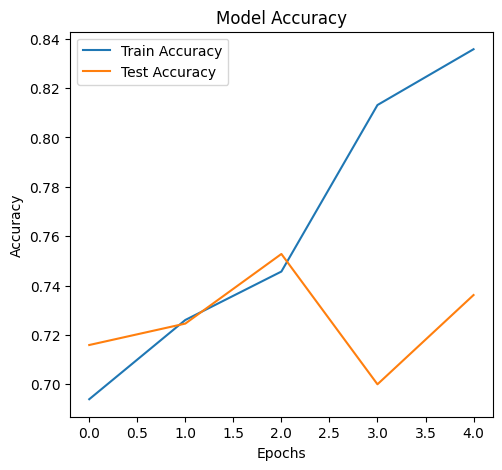

In [3]:
# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Test Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()


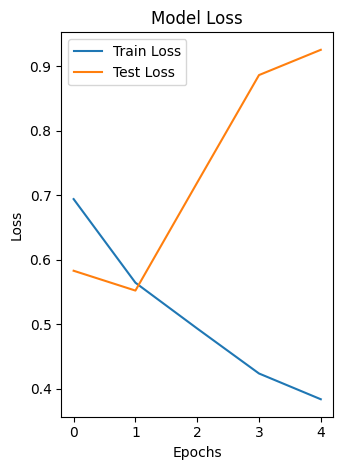

In [4]:
# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Test Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

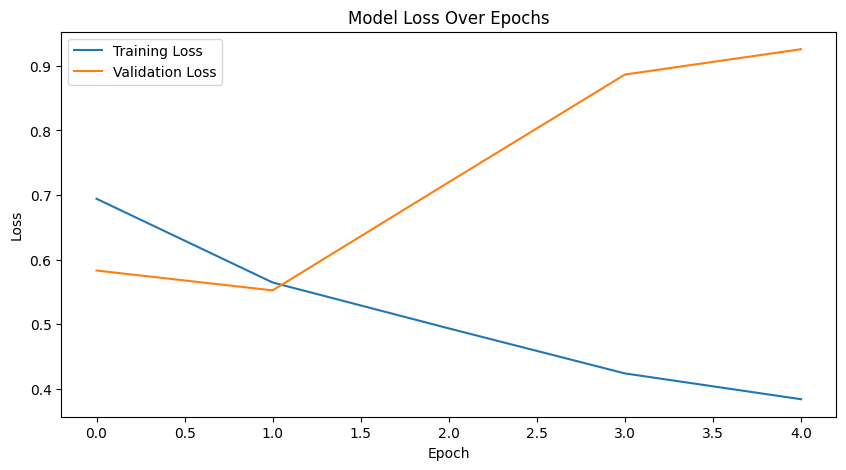

In [5]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()